# Permeation method for hydrogen transport properties in molten salt

In this notebook we'll describe the method employed to estimate the diffusivity and solubility of hydrogen in molten salt using a permeation rig.

The principle of the measurement is to have hydrogen diffusing through a membrane (here a salt, with a negligible metal membrane). The upstream pressure is kept constant and the downstream volume will experience a pressure rise. The steady state pressure rise then gives information on the salt permeability and the time-lag (detailed below) gives an insight on the diffusivity. The ratio of the permeability and diffusivity yields the solubility.

Note: having a closed downstream volume slightly differs from Fukada's experiment on FLiNaK (2006) where the authors swept the downstream gas at a constant rate.

The experimental pressure rise will be mimicked by an analytical solution and we will then quantify the error propagation.

## Generating the data
Let us first find the salt properties in the literature using HTM. We will use the Fukada 2006 paper.

In [336]:
import h_transport_materials as htm

ureg = htm.ureg
ureg.setup_matplotlib()

D_flinak = htm.diffusivities.filter(author="fukada", year=2006, material="flinak")[0]
K_flinak = htm.solubilities.filter(author="fukada", year=2006, material="flinak")[0]

print("Diffusivity:")
print(D_flinak)
print("Solubility:")
print(K_flinak)

Diffusivity:

        Author: Fukada
        Material: flinak
        Year: 2006
        Isotope: H
        Pre-exponential factor: 3.70×10⁻⁶ m²/s
        Activation energy: 4.50×10⁻¹ eV/particle
        
Solubility:

        Author: Fukada
        Material: flinak
        Year: 2006
        Isotope: H
        Pre-exponential factor: 2.03×10¹⁷ particle/Pa/m³
        Activation energy: -3.72e-01 eV/particle
        


The experimental parameters from the design of HYPERION 6/16/2023

<img width="500" alt="image" src="https://github.com/RemDelaporteMathurin/hyperion/assets/40028739/7772f7ec-649a-4a0b-8e58-9cf053cbdbe2">

In [337]:
import numpy as np

height = 3.04 * ureg.inch
radius = 3.07/2 * ureg.inch
T = (273 + 700) * ureg.K  # temperature
V_down = (np.pi * radius**2 * height).to(ureg.m**3) # downstream volume
A = (np.pi * radius**2).to(ureg.m**2)  # gas/salt interface surface area 
P_up = 101325 * ureg.Pa  # upstream pressure
L = (0.31*ureg.inch).to(ureg.m)  # salt thickness

# estimate properties at operating temperature
D_flinak = D_flinak.value(T)
K_flinak = K_flinak.value(T).to(ureg.mol * ureg.m**(-3) * ureg.Pa**-1)
permeability = D_flinak * K_flinak

We can now compute the transient analytical solution describing the downstream pressure rise.

$$P_\mathrm{down}(t) = R_g \ T \frac{A}{L \ V_\mathrm{down}} \ \Phi \ P_\mathrm{up} \left[t - \frac{L^2}{6 \ D} - \frac{2 \ L^2}{\pi^2 D} \sum_{n=1}^\infty \frac{(-1)^{n+1}}{n^2} \exp{\left( -\frac{D \ n^2 \pi^2}{L^2} t \right)}\right] $$

where $P_\mathrm{up}$ is the upstream pressure, $T$ is the temperature, $V$ is the downstream volume, $L$ is the thickness of salt, $R_g$ is the gas constant, and $A$ is the surface area of the gas/salt interface in the downstream chamber.

For more details, see:
- [Review of time lag permeation technique as a method for characterisation of porous media and membranes](https://link.springer.com/article/10.1007/BF01653631)
- [Hydrogen transport and trapping in ODS-EUROFER](https://doi.org/10.1016/j.fusengdes.2007.02.002)

In [338]:
timelag = L**2 / (6 * D_flinak)
Rg = htm.Rg  # gas constant

# Analytical solution for transient downstream pressure rise
def downstream_pressure(t):


    sum_term = 0
    for n in np.arange(1, 1000):
        sum_term += (
            (-1) ** (n+1) / n**2 * np.exp(-D_flinak * n**2 * np.pi**2 * t / L**2)
        )

    transient_term = 2 * L**2 / (np.pi**2 * D_flinak) * sum_term
    return Rg * T / V_down * A / L * permeability * P_up * (t - timelag + transient_term)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


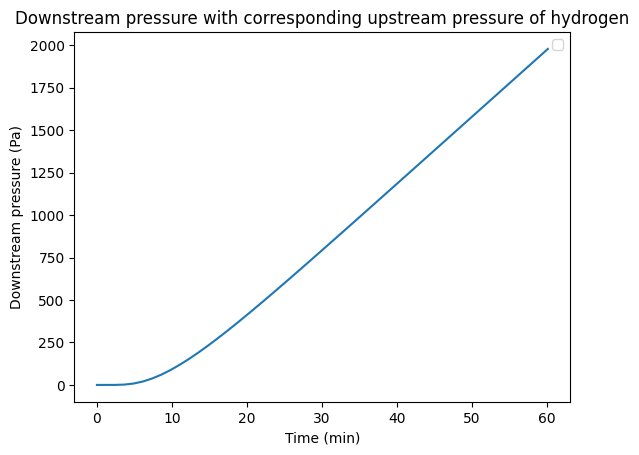

In [339]:
import matplotlib.pyplot as plt

t = np.linspace(0, 6 * timelag).to(ureg.min)
p_down = downstream_pressure(t).to(ureg.Pa)

plt.plot(t, p_down)
plt.legend()
plt.xlabel(f"Time ({t.units:~})")
plt.ylabel(f"Downstream pressure (Pa)")
plt.title("Downstream pressure with corresponding upstream pressure of hydrogen")
plt.show()


We can add some noise by assuming a 5% error on the low pressure side measurement.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3280: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.asarray(x, dtype=object)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3282: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y, dtype=object)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3321: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(err, dtype=object)


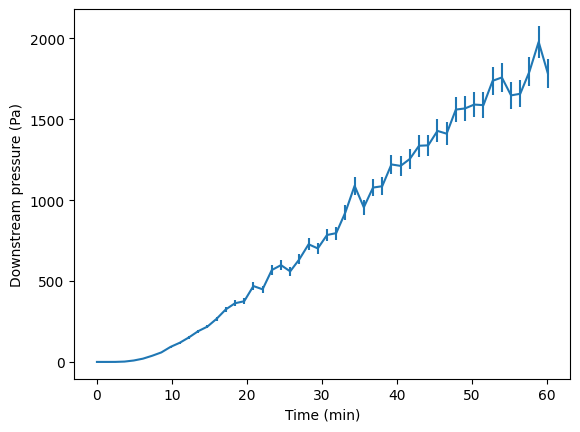

In [340]:
relative_p_down_error = 5/100
relative_noise = np.random.normal(0, relative_p_down_error, t.shape)

noisy_p_down = downstream_pressure(t) * (1 + relative_noise)
noisy_p_down = noisy_p_down.to(ureg.Pa)

yerr = relative_p_down_error*noisy_p_down

plt.errorbar(t, noisy_p_down, yerr=yerr)
plt.xlabel(f"Time ({t.units:~})")
plt.ylabel(f"Downstream pressure ({noisy_p_down.units:~})")
plt.show()

We fit the steady state pressure rise for $ t > 1200 \ \mathrm{min} $ with a linear function.


In [341]:
from scipy.optimize import curve_fit

# select only t > 1200 min
t_min_fit = 1200 * ureg.min
indices_fit = np.where(t > t_min_fit)
t_data_fit = t[indices_fit]
p_down_data_fit = noisy_p_down[indices_fit]
data_sigma_fit = relative_p_down_error * noisy_p_down[indices_fit]

# fit the curve

def linearFunc(x, intercept, slope):
    y = intercept + slope * x
    return y

res, cov = curve_fit(
    linearFunc,
    t_data_fit.to(ureg.s).magnitude,
    p_down_data_fit.to(ureg.Pa).magnitude,
    sigma=data_sigma_fit.to(ureg.Pa).magnitude,
    absolute_sigma=True,
)

fitted_intercept = res[0] * ureg.Pa
fitted_slope = res[1] * ureg.Pa * ureg.s**-1

# compute the uncertainties of slope and intercept
d_inter = np.sqrt(cov[0][0]) * ureg.Pa
d_slope = np.sqrt(cov[1][1]) * ureg.Pa * ureg.s**-1


print(f"Slope: {fitted_slope:.2e~P} with uncertainty {d_slope:.2e~P}")
print(f"Intercept: {fitted_intercept:.2f~P} with uncertainty {d_inter:.2f~P}")


ValueError: `ydata` must not be empty!

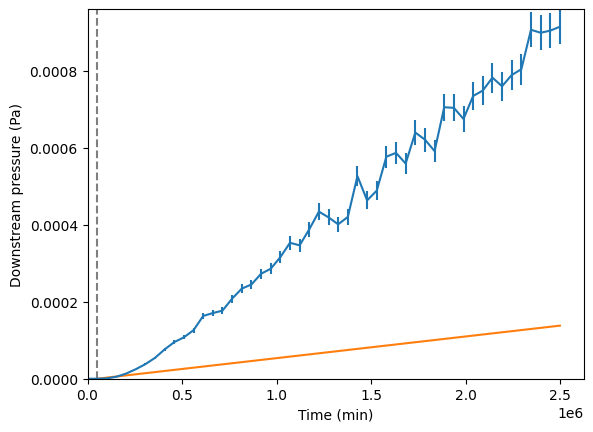

In [ ]:
timelag = -fitted_intercept/fitted_slope
t_fit = np.linspace(timelag, t.max()).to(ureg.min)

plt.errorbar(t, noisy_p_down, yerr=relative_p_down_error*noisy_p_down)
plt.plot(t_fit, linearFunc(t_fit, fitted_intercept, fitted_slope))

plt.axvline(x=timelag, linestyle="dashed", color="tab:grey")
plt.annotate(r"$\tau_\mathrm{timelag}$", (timelag*1.1, 300*ureg.Pa))

plt.xlabel(f"Time ({t.units:~})")
plt.ylabel(f"Downstream pressure ({noisy_p_down.units:~})")
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.show()

## Determination of H properties and uncertainty quantification

We use the `uncertainties` package to compute the error propagation of the permeation method.

The uncertainties associated with the slope and intercept are computed by `curve_fit` (see above).

Temperature: $\Delta T = 0.75 \ \%$

Upstream pressure: $\Delta P = 0.5 \ \%$

Downstream pressure: $\Delta P = 5 \ \%$ (already included in the noise, see above)

In [ ]:
from uncertainties import ufloat

slope_u = ufloat(
    fitted_slope.to(ureg.Pa * ureg.s**-1).magnitude,
    d_slope.to(ureg.Pa * ureg.s**-1).magnitude,
)
slope_u *= ureg.Pa * ureg.s**-1


intercept_u = ufloat(
    fitted_intercept.to(ureg.Pa).magnitude,
    d_inter.to(ureg.Pa).magnitude,
)
intercept_u *= ureg.Pa

T = T.to(ureg.K)
T_u = ufloat(T.magnitude, 0.75 / 100 * T.magnitude) * ureg.K

P_up = P_up.to(ureg.Pa)
P_up_u = ufloat(P_up.magnitude, 0.5 / 100 * P_up.magnitude) * ureg.Pa


ModuleNotFoundError: No module named 'uncertainties'

### Permeability

The permeability $\Phi$ is given by:

$$\Phi = \frac{S}{P_\mathrm{up} \ T} \ \frac{V \ L}{R_g \ A} $$

where $S$ is the slope of the pressure rise.

In [ ]:
permeability_u = slope_u * P_up_u**-1 * T_u**-1 * V_down * L / Rg / A
permeability_u = permeability_u.to(ureg.particle * ureg.m**-1 * ureg.Pa**-1 * ureg.s**-1)

print(f"Measured: {permeability_u:~P}")
print(f"Real: {D_flinak*K_flinak:.2e~P}")

Measured: (2.75+/-0.06)e+11 particle/Pa/m/s
Real: 2.72×10¹¹ particle/Pa/m/s


### Diffusivity

The timelag $\tau_\mathrm{timelag}$ is defined as:
$$\tau_\mathrm{timelag} = \frac{L^2}{6 \ D}$$

where $D$ is the diffusivity.


The timelag corresponds to the time when the linear pressure rise curve intersects with the X axis.

$$P(t=\tau_\mathrm{timelag}) = 0$$

wich can be written as:

$$S \ \tau_\mathrm{timelag} + I = 0$$

where $S$ and $I$ are respectively the slope and the intercept of the steady pressure rise curve.


The diffusivity $D$ can therefore be expressed by:

$$D = \frac{S}{6 \ I} \ L^2$$


In [ ]:
diffusivity_u = -slope_u/(6 * intercept_u) * L**2
diffusivity_u = diffusivity_u.to(ureg.m**2 * ureg.s**-1)

print(f"Measured: {diffusivity_u:~P}")
print(f"Real: {D_flinak:.2e~P}")

Measured: (1.02+/-0.10)e-08 m²/s
Real: 1.11×10⁻⁸ m²/s


### Solubility
The solubility $K_H$ is given as:

$$K_H = \Phi / D$$

In [ ]:
solubility_u = permeability_u / diffusivity_u
solubility_u = solubility_u.to(ureg.particle * ureg.m**-3 * ureg.Pa**-1)

print(f"Measured: {solubility_u:~P}")
print(f"Real: {K_flinak:.2e~P}")

Measured: (2.70+/-0.25)e+19 particle/Pa/m³
Real: 2.45×10¹⁹ particle/Pa/m³


## Conclusion

The permeation method is a well-established method for measuring diffusivities and solubilities of metals but also molten salts.

The uncertainty associated with diffusivities and solubilities are reasonable ($<10 \ \%$).
Moreover, efforts aiming to reduce the uncertainty of the downstream pressure measurement will help driving the overall error down.

### TODO: what would be the error associated with geometrical measurements?